# Data Gathering

We will start by getting the data from the 'fashion_dataset' directory.

In [15]:
!wget https://github.com/mohamed-12-4/DSAI--COSC-202-/raw/refs/heads/master/fashion_dataset.zip
!unzip fashion_dataset

Streaming output truncated to the last 5000 lines.
  inflating: fashion_dataset/9/18732.png  
  inflating: fashion_dataset/9/18739.png  
  inflating: fashion_dataset/9/18744.png  
  inflating: fashion_dataset/9/18746.png  
  inflating: fashion_dataset/9/18756.png  
  inflating: fashion_dataset/9/18770.png  
  inflating: fashion_dataset/9/18795.png  
  inflating: fashion_dataset/9/18806.png  
  inflating: fashion_dataset/9/18819.png  
  inflating: fashion_dataset/9/18836.png  
  inflating: fashion_dataset/9/18843.png  
  inflating: fashion_dataset/9/18857.png  
  inflating: fashion_dataset/9/1889.png  
  inflating: fashion_dataset/9/18892.png  
  inflating: fashion_dataset/9/18899.png  
  inflating: fashion_dataset/9/18902.png  
  inflating: fashion_dataset/9/18931.png  
  inflating: fashion_dataset/9/18941.png  
  inflating: fashion_dataset/9/18954.png  
  inflating: fashion_dataset/9/18955.png  
  inflating: fashion_dataset/9/18969.png  
  inflating: fashion_dataset/9/18973.png  
  in

In [16]:
import os
import glob
import pandas as pd
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def load_data(path: str) -> pd.DataFrame:
    """
    Load the data from the path and return a pandas dataframe with the images path and labels.
    param path: str: path to the images directory
    """
    images = []
    labels = []
    for image_path in glob.glob(path + '/*/*.png'):
        images.append(image_path)
        labels.append(image_path.split('/')[-2])

    images_df = pd.DataFrame({'images_path': images, 'labels': labels})
    return images_df



In [18]:
images_df = load_data('./fashion_dataset')

In [19]:
images_df

,images_path,labels
0,./fashion_dataset/6/5323.png,6
1,./fashion_dataset/6/14080.png,6
2,./fashion_dataset/6/44091.png,6
3,./fashion_dataset/6/26216.png,6
4,./fashion_dataset/6/45909.png,6
...,...,...
59995,./fashion_dataset/3/49795.png,3
59996,./fashion_dataset/3/8528.png,3
59997,./fashion_dataset/3/27657.png,3
59998,./fashion_dataset/3/2165.png,3


In [20]:
images_df.labels.value_counts()
images_df.labels = images_df.labels.astype(int)

In [21]:
images_df

,images_path,labels
0,./fashion_dataset/6/5323.png,6
1,./fashion_dataset/6/14080.png,6
2,./fashion_dataset/6/44091.png,6
3,./fashion_dataset/6/26216.png,6
4,./fashion_dataset/6/45909.png,6
...,...,...
59995,./fashion_dataset/3/49795.png,3
59996,./fashion_dataset/3/8528.png,3
59997,./fashion_dataset/3/27657.png,3
59998,./fashion_dataset/3/2165.png,3


In [22]:
labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def class_to_name(label) -> str:
    """
    Convert the label to the name of the class
    param label: int: label of the class
    """

    return labels_map[label]

Sneaker


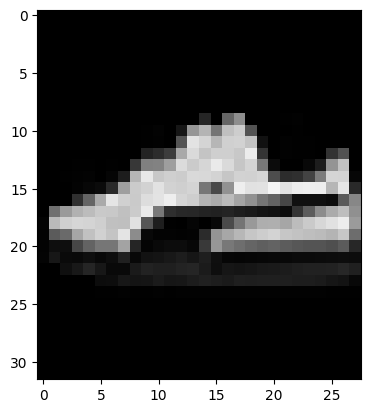

In [23]:
def view_image(path: str):
    """
    View the image from the path
    param path: str: path to the image
    """
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = cv2.imread(path)
    plt.imshow(img)

index = random.randint(0, len(images_df))
image_path = images_df.images_path[index]
label = images_df.labels[index]
print(class_to_name(label))
view_image(image_path)


<Axes: ylabel='count'>

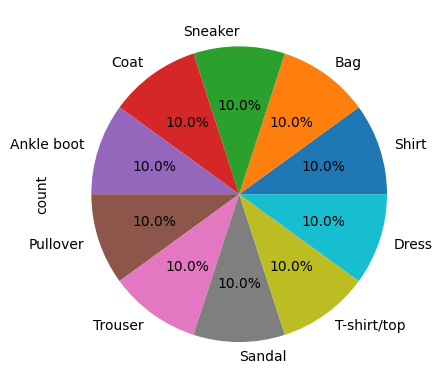

In [24]:
# plot a pie plot of the classes
images_df['class_name'] = images_df['labels'].apply(class_to_name)

images_df.class_name.value_counts().plot(kind='pie', autopct='%1.1f%%', )

# Trying different models

In [25]:
def create_dataset(df: pd.DataFrame, batch_size: int):
    """
    Create the dataset from the dataframe
    param df: pd.DataFrame: dataframe with the images path and labels
    """
    imagegen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
    dataset = imagegen.flow_from_dataframe(
        df,
        x_col='images_path',
        y_col='labels',
        target_size=(28, 28),
        class_mode='raw',
        batch_size=batch_size,
    )
    return dataset



In [34]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(images_df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [35]:
dataset = create_dataset(images_df, 64)
train_dataset = create_dataset(train_df, 64)
test_dataset = create_dataset(test_df, 64)
val_dataset = create_dataset(val_df, 64)

Found 60000 validated image filenames.
Found 48000 validated image filenames.
Found 6000 validated image filenames.
Found 6000 validated image filenames.


In [27]:
len(dataset)

938

In [28]:
dataset[0][1]

array([8, 1, 2, 6, 2, 5, 2, 7, 4, 4, 7, 4, 0, 3, 6, 0, 8, 3, 3, 2, 5, 4,
       0, 7, 8, 9, 4, 9, 7, 3, 5, 2, 3, 8, 7, 4, 2, 3, 9, 0, 2, 5, 8, 9,
       0, 5, 2, 4, 7, 5, 4, 9, 8, 2, 9, 3, 4, 9, 2, 6, 4, 5, 6, 5])

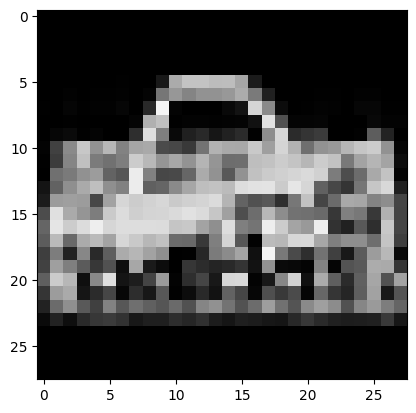

In [29]:
plt.imshow(dataset[0][0][0])

# Convolutiol NN

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,898 (366.79 KB)

 Trainable params: 93,898 (366.79 KB)

 Non-trainable params: 0 (0.00 B)

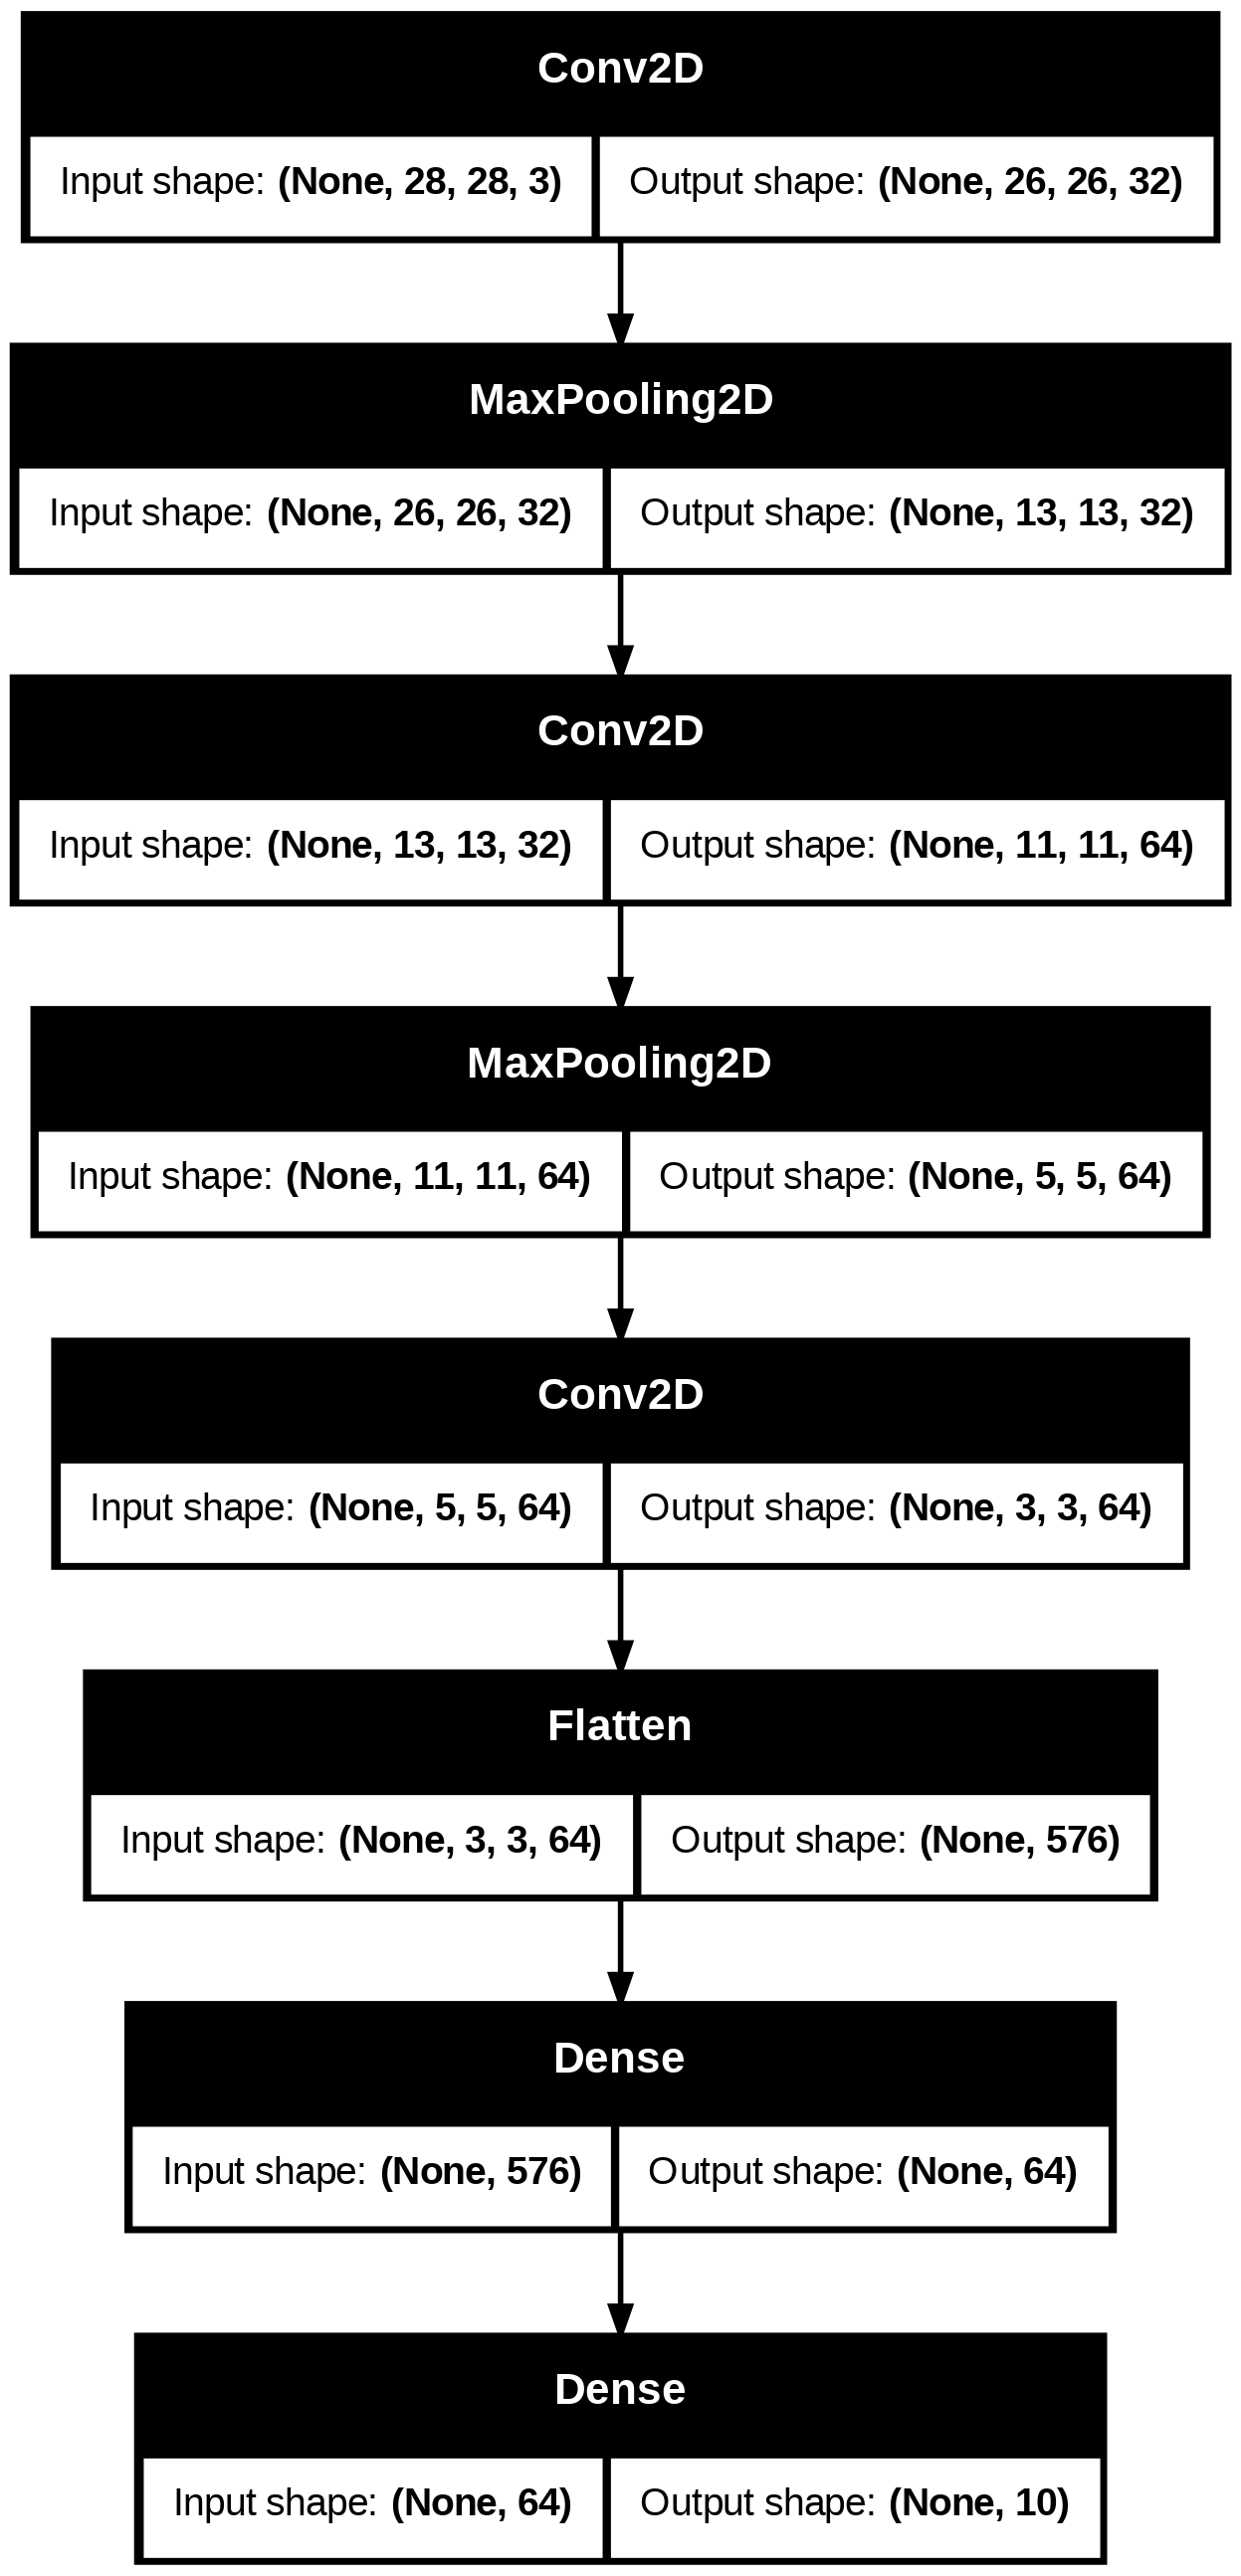

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=100, callbacks=[callback], validation_data=val_dataset)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 72s 93ms/step - accuracy: 0.7156 - loss: 0.7985 - val_accuracy: 0.8512 - val_loss: 0.4209
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.8619 - loss: 0.3888 - val_accuracy: 0.8767 - val_loss: 0.3489
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.8822 - loss: 0.3193 - val_accuracy: 0.8833 - val_loss: 0.3270
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.8939 - loss: 0.2878 - val_accuracy: 0.8863 - val_loss: 0.3207
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step - accuracy: 0.9074 - loss: 0.2545 - val_accuracy: 0.8940 - val_loss: 0.2939
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 89ms/step - accuracy: 0.9115 - loss: 0.2352 - val_accuracy: 0.8963 - val_loss: 0.2944
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 85ms/step - accuracy: 0.9193 - loss: 0.2186 - val_accuracy: 0.8977 - val_loss: 0.2858
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9256 - loss: 0.2002 - val_

KeyboardInterrupt: 

In [37]:
model.evaluate(test_dataset)

 2/94 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8906 - loss: 0.2792  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9104 - loss: 0.2739


[0.26269930601119995, 0.9131666421890259]